## Optimización de Portafolios
### Sesión 3 (18-06-2021)

#### Modelos Factoriales: de CAPM a Fama-French y más

Terminamos la sesión anterior habiendo definido el modelo de _Capital Asset Pricing Model_ (CAPM) como una herramienta de análisis (para _pricear_ portafolios bien diversificados así como activos individuales y portafolios en general).

Contamos entonces con dos herramientas:
* **Capital Market Line (CML)**: Herramienta para *pricear* portafolios bien diversificados.

$E(R_i\ ) = R_f + \sigma_p \cdot\frac{E(R_M) - R_f}{\sigma_M} $
    
Surgen de una combinación entre el portafolio de tangencia (de mercado) y un activo libre de riesgo. Terminan siendo una extensión de la frontera eficiente (de activos riesgosos), con un único punto en común -en el portafolio de Mercado, **M**-. Los portafolios que se encuentran en la _CML_ van a terminar siendo los portafolios que ofrecen un perfil de riesgo-retorno superador (y constante a través de la recta). De aquí derivamos también la definición del ratio de _Sharpe_ (la pendiente de la _CML_):

$ SR = \frac{E(R) - R_f}{\sigma}$

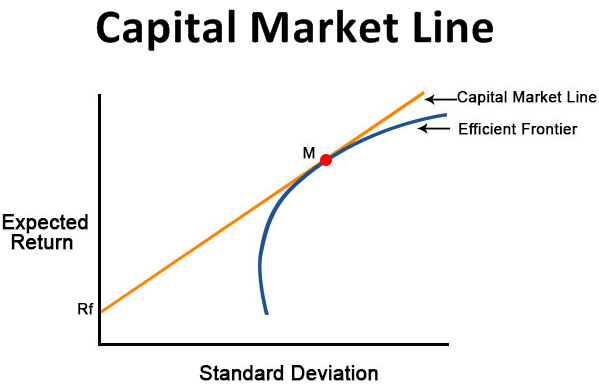
_Fuente_: WallStreetMojo.com

* **Security Market Line (SML)**: Herramienta para *pricear* activos individuales 
    
derivada de la MPT (sumado a los desarrollos de Tobin y Sharpe) bajo

$ E(R_i) = R_f + \beta_{i}(E(R_m) - R_f) $

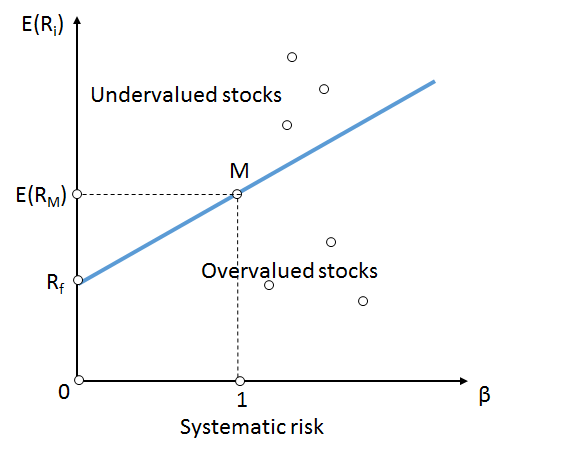
_Fuente_: Wikipedia

Donde $\beta_{i}$ es la sensibilidad al exceso de retorno de mercado (por sobre la libre de riesgo), y en términos de fórmula es $\beta_{i} = \frac{\mathrm{Cov}(R_i,R_m)}{\mathrm{Var}(R_m)} = \rho_{i,m} \frac{\sigma_{i}}{\sigma_{m}}$


#### Empezamos los desarrollos

Bajamos primero los componentes del S&P 500 en base a la tabla de componentes presente en [Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import statsmodels.api as sm
import random
#import pyfinance as pf
from pandas_datareader import data as pdr
from pypfopt import expected_returns
from pypfopt import risk_models
from datetime import datetime
import warnings
plt.style.use('seaborn-colorblind')
warnings.filterwarnings("ignore")


In [2]:
## bajamos la tabla de wikipedia del s&p 500
## read_html lee el html de la página y te deja extraer las tablas
data = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",header=0)
table = data[0]
table.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
## toma la columna "Symbol" y cuenta cuantas entradas hay: s&p 500 tiene 505 acciones
list_symbols = list(table.loc[:,"Symbol"])
#list_symbols
len(list_symbols)

505

In [4]:
## el comentario dice "elijamos un lote aleatorio"
## pero la linea que elige al azar está comentada
## se puede descomentar y comentar la de abajo para tener un lote aleatorio
## por ahora nos quedamos con el conjunto de tickers que eligió el profe:

# elijamos un lote aleatorio de tickers
#asset_list = random.sample(list_symbols, 5)
asset_list = [ 'XLC' , 'XLY' , 'XLP' , 'XLE' , 'XLF' , 'XLV' , 'XLI' , 'XLB' , 'XLRE' , 'XLK' , 'XLU' , 'SPY']
asset_list


['XLC',
 'XLY',
 'XLP',
 'XLE',
 'XLF',
 'XLV',
 'XLI',
 'XLB',
 'XLRE',
 'XLK',
 'XLU',
 'SPY']

In [5]:
# Obtenemos la data histórica de precios

## inicializa un dataframe vacio
prices = pd.DataFrame()

## define una fecha de inicio y fecha de fin. Datetime permite generar un tipo de dato para trabajar fechas
## start es el 1/1/2020 y end es la fecha de hoy (sea cual sea el día que corras este código)
start = dt.datetime(2010,1,1)
end = dt.date.today()
#end = end.strftime("%Y-%m-%d")

## para cada ticker de la lista que definió, usa data reader para bajarlo de yahoo entre las fechas
## que definió arriba y lo guarda en una columna del dataframe "prices"
for s in asset_list:
    print(s)
    #prices[s] = yf.download(s, start = '2010-01-01')['Adj Close']
    prices[s] = pdr.DataReader(s, data_source='yahoo', start=start, end=end)['Adj Close']
    
prices.head()

XLC
XLY
XLP
XLE
XLF
XLV
XLI
XLB
XLRE
XLK
XLU
SPY


,XLC,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLRE,XLK,XLU,SPY
Date,,,,,,,,,,,,
2018-06-19,48.642857,107.982346,46.998981,63.274002,25.628988,80.264877,69.123398,54.952522,28.397831,68.771698,45.474594,261.835693
2018-06-20,49.246521,108.494339,47.045013,63.553394,25.563393,80.435127,69.170593,54.774010,28.704348,68.916107,45.510834,262.282379
2018-06-21,48.944691,107.721527,47.137054,62.376621,25.488426,79.971657,68.302185,54.191513,28.875635,68.386589,45.664867,260.638153
2018-06-22,49.158890,107.537971,47.523659,63.621117,25.366608,80.331085,68.538170,54.980713,29.128061,68.165154,45.981976,261.113373
2018-06-25,48.146313,105.200195,47.762974,62.342758,25.094858,79.593307,67.669754,54.125748,29.055939,66.749863,46.743053,257.558838


In [6]:
## convierte los precios en retornos % (no log)

# De precios a retornos
returns = prices.pct_change().dropna()
returns

,XLC,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLRE,XLK,XLU,SPY
Date,,,,,,,,,,,,
2018-06-20,0.012410,0.004741,0.000979,0.004416,-0.002559,0.002121,0.000683,-0.003248,0.010794,0.002100,0.000797,0.001706
2018-06-21,-0.006129,-0.007123,0.001956,-0.018516,-0.002933,-0.005762,-0.012555,-0.010635,0.005967,-0.007684,0.003385,-0.006269
2018-06-22,0.004376,-0.001704,0.008202,0.019951,-0.004779,0.004494,0.003455,0.014563,0.008742,-0.003238,0.006944,0.001823
2018-06-25,-0.020598,-0.021739,0.005036,-0.020093,-0.010713,-0.009184,-0.012671,-0.015550,-0.002476,-0.020763,0.016552,-0.013613
2018-06-26,0.001658,0.007163,-0.004240,0.012629,-0.003361,-0.003089,0.003766,0.003819,0.005275,0.004038,0.001163,0.002214
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-17,0.004168,0.003770,0.003582,-0.033995,-0.029570,0.007648,-0.015415,-0.022278,0.003789,0.011569,0.005500,-0.000332
2021-06-18,-0.011697,-0.005258,-0.017704,-0.029635,-0.024100,-0.011425,-0.012981,-0.016206,-0.015764,-0.009135,-0.025984,-0.016707
2021-06-21,0.009702,0.007708,0.011469,0.042615,0.023339,0.012015,0.021995,0.020761,0.019866,0.010717,0.012955,0.014316


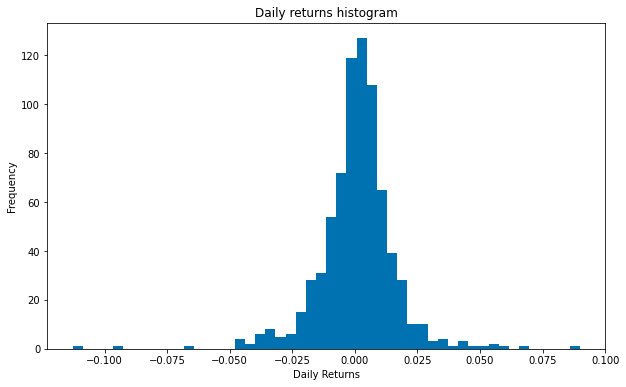

In [7]:
## hace un histograma de los retornos % de XLC
returns['XLC'].plot.hist(bins=50, figsize=(10,6));
plt.xlabel('Daily Returns')
plt.title('Daily returns histogram')
plt.show()



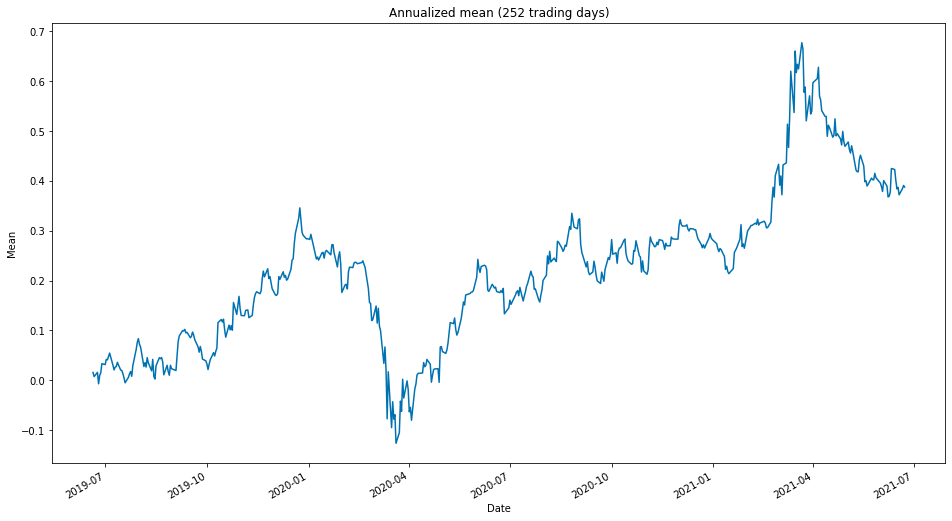

In [8]:
## toma el ticker XLC y hace una media movil de 252 días. Al resultado lo multiplica por 252
mu = returns['XLC'].rolling(window=252).mean()*252

fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(1, 1, 1)
mu.plot(ax=ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Mean')
ax1.set_title('Annualized mean (252 trading days)')
plt.show()

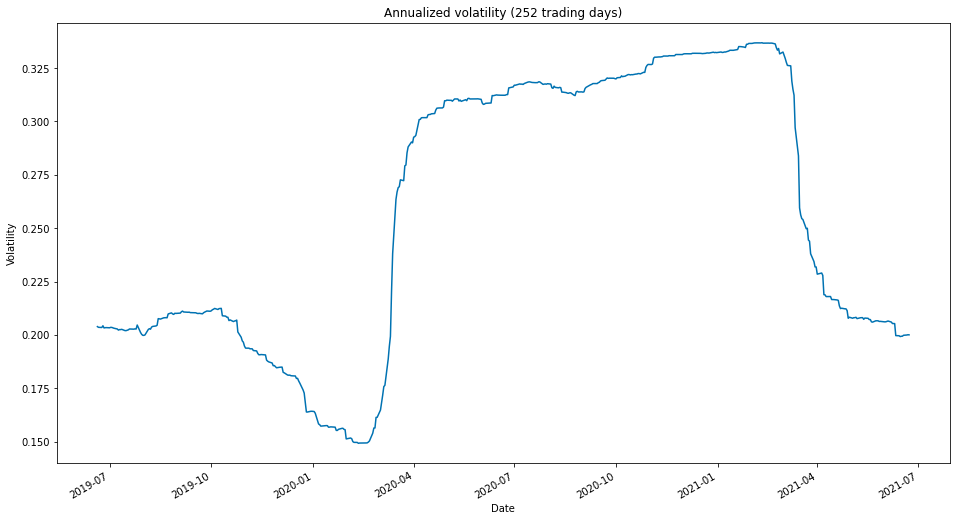

In [9]:
## toma el ticker XLC y hace un desvío estandar móvil (como una media movil, pero con el desvío estándar)
## multiplica cada desvío estandar por la raiz cuadrada de 252
vol = returns['XLC'].rolling(window=252).std()*np.sqrt(252)

fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(1, 1, 1)
vol.plot(ax=ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility')
ax1.set_title('Annualized volatility (252 trading days)')
plt.show()


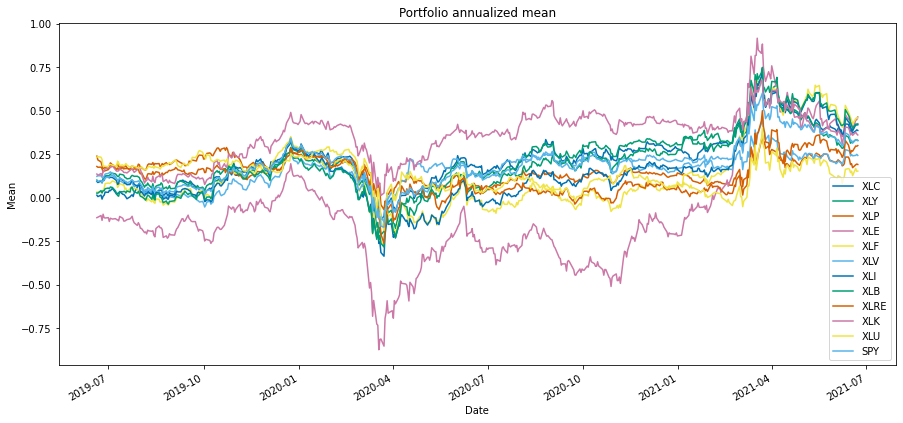

In [10]:
## ahora calcula una media movil de 252 dias y lo multiplica por 252 pero para cada ticker
mu_portfolio = returns.rolling(window=252).mean()*252
#mu_portfolio.tail()

## y los grafica:
fig = plt.figure(figsize=(15, 7))
ax2 = fig.add_subplot(1, 1, 1)
mu_portfolio.plot(ax=ax2)
ax2.set_xlabel('Date')
ax2.set_ylabel('Mean')
ax2.set_title('Portfolio annualized mean')
plt.show()

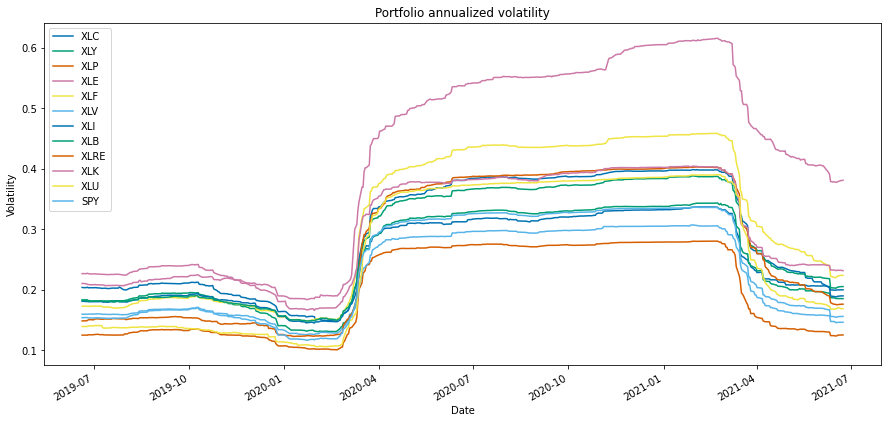

In [11]:
## ahora repite para volatilidad: toma un desvío estándar móvil de 252 días para todos los 
## tickers que había tomado. Multiplica cada uno por la raíz cuadrada de 252
volatility_portfolio = returns.rolling(window=252).std()*np.sqrt(252)
volatility_portfolio.tail()

fig = plt.figure(figsize=(15, 7))
ax2 = fig.add_subplot(1, 1, 1)
volatility_portfolio.plot(ax=ax2)
ax2.set_xlabel('Date')
ax2.set_ylabel('Volatility')
ax2.set_title('Portfolio annualized volatility')
plt.show()

### Fama French (extensión a 5 factores)

$ r = R_f + b_m \cdot \text{ER} + b_s \cdot \text{SMB} + b_v \cdot \text{HML} + b_p \cdot \text{RMW} + b_i \cdot \text{CMA} $

$r$ es el retorno esperado \
$b_m$, $b_s$, $b_v$, $b_p$, $b_i$ son las sensibilidades

#### Factors Analysis
$\text{ER}$ Es el exceso de retorno del mercado por sobre la libre de riesgo ($R_m - R_f$) (**factor "MERCADO"**) \
$\text{SMB}$ Es el retorno promedio a estar expuesto al tamaño de las empresas (**factor "SMALL MINUS BIG"**) \
$\text{HML}$ Es el retorno promedio a estar expuesto a un portafolio de *high value* menos un portafolio de *low value*, medido en término de book value (**factor "VALUE"**) \
$\text{RMW}$ Es el retorno promedio de un portafolio long activos *robusto* y short activos *débiles* en términos del *operating profitability* (**factor "PROFITABILITY"**) \
$\text{CMA}$ Es el retorno promedio de un portafolio long activos *conservadores* y short activos *agresivos*, vía una aproximación tomando en cuenta el crecimiento TTM de la compañía (**factor "INVESTMENT"**)


In [12]:
## en el proximo bloque va a descargar y deszippear data de la página de french
## y despues va a levantar el csv.
## pero esto también podría reemplazarse por algo como lo que vimos en la notebook de rolling betas
## que directamente usa pandas datareader para bajar la data de fama french

In [13]:
## este es el original, con una corrección sobre la extensión del archivo csv

import urllib.request
import zipfile
ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
# Download the file and save it
# We will name it fama_french.zip file

## baja el archivo zip
urllib.request.urlretrieve(ff_url,'fama_french.zip')

## lo abre
zip_file = zipfile.ZipFile('fama_french.zip', 'r')

## extrae la data  del zip
zip_file.extractall()

## cierra el zip
zip_file.close()

## abre el csv
ff_factors = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows = 3)

In [14]:
## los proximos bloques de código parecen ser los mismos a los 
## de la notebook de la sesion dos, así que voy a comentar rapidito nomás
## el código es practicamente el mismo que en esa otra notebook:
## hay diferencias en el bloque 24

## además, en vez de presentar el modelo de 5 factores, en esta notebook presenta el modelo de 3

In [15]:
## muestra las primeras filas del dataframe
print(ff_factors.head())

  Unnamed: 0    Mkt-RF       SMB       HML        RF
0     192607      2.96     -2.30     -2.87      0.22
1     192608      2.64     -1.40      4.19      0.25
2     192609      0.36     -1.32      0.01      0.23
3     192610     -3.24      0.04      0.51      0.32
4     192611      2.53     -0.20     -0.35      0.31


In [16]:
## muestra las ultimas filas del dataframe
print(ff_factors.tail(100))

                              Unnamed: 0    Mkt-RF       SMB       HML  \
1135                              202102      2.78      2.11      7.08   
1136                              202103      3.08     -2.48      7.40   
1137                              202104      4.94     -3.09     -0.75   
1138   Annual Factors: January-December        NaN       NaN       NaN   
1139                                 NaN    Mkt-RF       SMB       HML   
...                                  ...       ...       ...       ...   
1230                                2017     21.51     -4.96    -13.84   
1231                                2018     -6.93     -3.15     -9.34   
1232                                2019     28.28     -6.26    -10.68   
1233                                2020     23.67     13.07    -47.20   
1234    Copyright 2021 Kenneth R. French       NaN       NaN       NaN   

            RF  
1135      0.00  
1136      0.00  
1137      0.00  
1138       NaN  
1139        RF  
...      

In [17]:
#muestra de las filas 1133 a 1137

#print(ff_factors.iloc[1124:1138],)
ff_factors[:1138].tail()

,Unnamed: 0,Mkt-RF,SMB,HML,RF
1133,202012,4.63,4.81,-1.36,0.01
1134,202101,-0.03,7.19,2.85,0.00
1135,202102,2.78,2.11,7.08,0.00
1136,202103,3.08,-2.48,7.40,0.00
1137,202104,4.94,-3.09,-0.75,0.00


In [18]:
## levanta el csv, elimina las primeras 3 filas y toma hasta la fiula 1138
## muesrtra las ultimas 5

ff_factors = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows = 3,
nrows = 1138)
ff_factors.tail()
#ff_factors.head()

,Unnamed: 0,Mkt-RF,SMB,HML,RF
1133,202012,4.63,4.81,-1.36,0.01
1134,202101,-0.03,7.19,2.85,0.00
1135,202102,2.78,2.11,7.08,0.00
1136,202103,3.08,-2.48,7.40,0.00
1137,202104,4.94,-3.09,-0.75,0.00


In [19]:
## hace lo mismo que en la anterior pero setea la primer columna como índice (index_col = 0)
ff_factors = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows = 3,nrows = 1138, index_col = 0)
ff_factors.tail()

,Mkt-RF,SMB,HML,RF
202012,4.63,4.81,-1.36,0.01
202101,-0.03,7.19,2.85,0.00
202102,2.78,2.11,7.08,0.00
202103,3.08,-2.48,7.40,0.00
202104,4.94,-3.09,-0.75,0.00


In [20]:
## convierte le indice a formato de fecha (to_datetime)

ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m')
ff_factors.tail()

,Mkt-RF,SMB,HML,RF
2020-12-01,4.63,4.81,-1.36,0.01
2021-01-01,-0.03,7.19,2.85,0.00
2021-02-01,2.78,2.11,7.08,0.00
2021-03-01,3.08,-2.48,7.40,0.00
2021-04-01,4.94,-3.09,-0.75,0.00


In [21]:
## como el índice está como si fuera le primer día del més, lo pasa al último:

ff_factors.index = ff_factors.index + pd.offsets.MonthEnd()
ff_factors.tail()

,Mkt-RF,SMB,HML,RF
2020-12-31,4.63,4.81,-1.36,0.01
2021-01-31,-0.03,7.19,2.85,0.00
2021-02-28,2.78,2.11,7.08,0.00
2021-03-31,3.08,-2.48,7.40,0.00
2021-04-30,4.94,-3.09,-0.75,0.00


In [22]:
## divide los retornos de los factores por 100
ff_factors = ff_factors.apply(lambda x: x/ 100)
ff_factors.tail()

,Mkt-RF,SMB,HML,RF
2020-12-31,0.0463,0.0481,-0.0136,0.0001
2021-01-31,-0.0003,0.0719,0.0285,0.0000
2021-02-28,0.0278,0.0211,0.0708,0.0000
2021-03-31,0.0308,-0.0248,0.0740,0.0000
2021-04-30,0.0494,-0.0309,-0.0075,0.0000


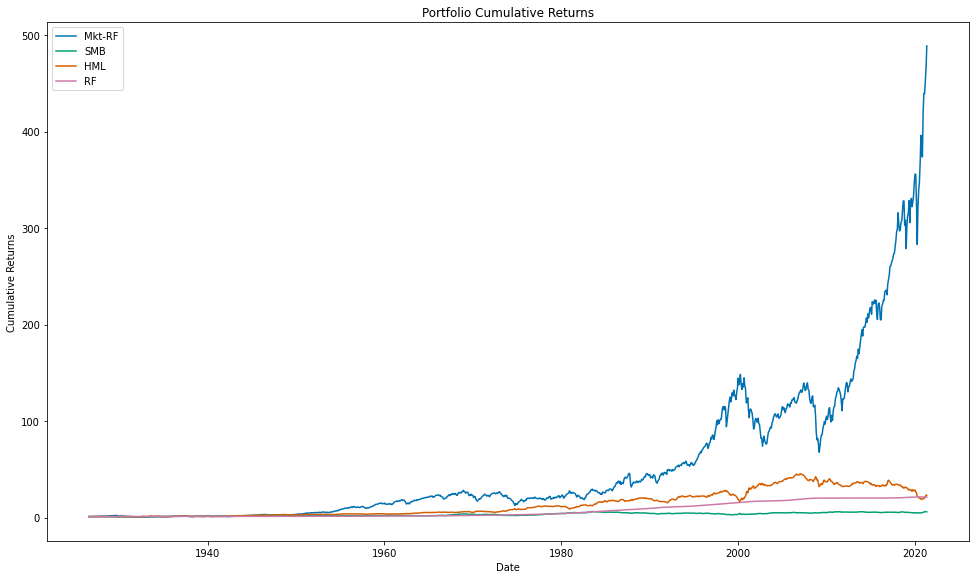

In [23]:
## le suma 1 y hace el producto acumulado de los retornos para componerlos:

cumulative_factor_returns = (ff_factors + 1).cumprod()

## Nota: como charlamos en el grupo, estos son los retornos acumulados. 
## para leerlo como retorno hay que restarle 1:
## cumulative_factor_returns = (ff_factors + 1).cumprod() -1


fig = plt.figure(figsize=(16,9))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(cumulative_factor_returns)
ax1.set_xlabel('Date')
ax1.legend(cumulative_factor_returns.columns, loc = 'upper left')
ax1.set_ylabel("Cumulative Returns")
ax1.set_title("Portfolio Cumulative Returns")
plt.show();

In [24]:
## acá retoma los precios que descargó previamente
## los resamplea para tener los precios a fin de mes (último día hábil)
## si hay algun dato faltante lo completa con el último válido (ffill)
monthly_prices = prices.asfreq('BM').ffill()

## y calcula los retornos mensuales
monthly_returns = monthly_prices.pct_change().dropna()
monthly_returns.tail()


,XLC,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLRE,XLK,XLU,SPY
Date,,,,,,,,,,,,
2021-01-29,-0.008892,0.007650,-0.049815,0.037467,-0.017978,0.014016,-0.042688,-0.024175,0.005470,-0.008383,-0.008772,-0.010190
2021-02-26,0.070126,-0.005308,-0.012326,0.224568,0.116062,-0.021038,0.068892,0.041195,0.015778,0.013651,-0.060981,0.027805
2021-03-31,0.026262,0.044598,0.084982,0.029710,0.058524,0.040273,0.089869,0.075904,0.068139,0.019029,0.105521,0.045399
2021-04-30,0.064512,0.064556,0.018592,0.006726,0.064905,0.039318,0.035348,0.053807,0.083059,0.051879,0.041849,0.052910
2021-05-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [25]:
## ahora mergea los retornos mensuales con los factores.
## es decir, combina las filas de ambos dataframes uniendo por el index (la fecha)
all_data = pd.merge(pd.DataFrame(monthly_returns),ff_factors, how = 'inner', left_index= True, right_index= True)


## a los retornos le suma 1 y hace el producto acumulado y eso lo guarda en cumulative_factor_returns
cumulative_factor_returns = (all_data + 1).cumprod() # -1
## lo mismo que arriba: para leerlo como retorno hay que restarle 1 
cumulative_factor_returns.shape

(24, 16)

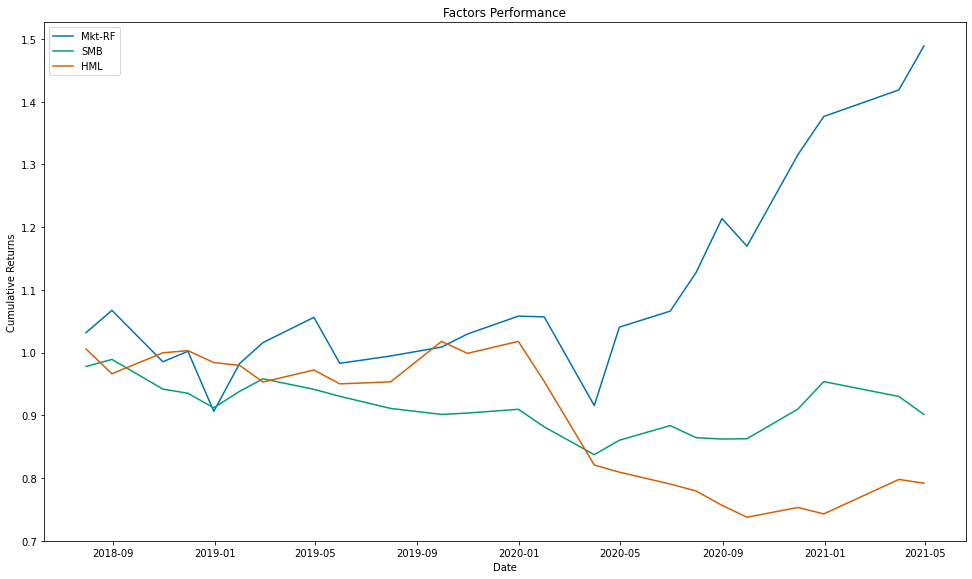

In [26]:
## plotea cumulative_factor_returns

fig = plt.figure(figsize=(16,9))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(cumulative_factor_returns.iloc[:,12:15])
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Returns')
ax1.set_title('Factors Performance')
ax1.legend(cumulative_factor_returns.iloc[:,12:15].columns, loc = 'upper left')
plt.show()

In [27]:
## le cambia el nombre a mkt-rf a mkt_excess
all_data.rename(columns={"Mkt-RF":"mkt_excess"}, inplace=True)


## calcula el exceso de retorno: para cada ticker, toma la columna y le resta la risk free
## guarda eso en una columna nueva con el nombre del ticker y _excess
## Por ejempolo: XLP_excess es el retorno de XLP - la risk free de ese mes
for nombres in asset_list:
    all_data[nombres + '_excess'] = all_data[nombres] - all_data['RF']

all_data.tail()

,XLC,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLRE,XLK,...,XLP_excess,XLE_excess,XLF_excess,XLV_excess,XLI_excess,XLB_excess,XLRE_excess,XLK_excess,XLU_excess,SPY_excess
2020-09-30,-0.059032,-0.018634,-0.016748,-0.146066,-0.034222,-0.021805,-0.006822,0.015076,-0.021178,-0.053351,...,-0.016848,-0.146166,-0.034322,-0.021905,-0.006922,0.014976,-0.021278,-0.053451,0.010713,-0.037544
2020-11-30,0.104730,0.099951,0.074687,0.279944,0.168483,0.079481,0.160274,0.123615,0.068814,0.113837,...,0.074587,0.279844,0.168383,0.079381,0.160174,0.123515,0.068714,0.113737,0.007274,0.108677
2020-12-31,0.033452,0.024278,0.016510,0.044801,0.063060,0.037978,0.010068,0.024816,0.014619,0.055416,...,0.016410,0.044701,0.062960,0.037878,0.009968,0.024716,0.014519,0.055316,0.006104,0.036948
2021-03-31,0.026262,0.044598,0.084982,0.029710,0.058524,0.040273,0.089869,0.075904,0.068139,0.019029,...,0.084982,0.029710,0.058524,0.040273,0.089869,0.075904,0.068139,0.019029,0.105521,0.045399
2021-04-30,0.064512,0.064556,0.018592,0.006726,0.064905,0.039318,0.035348,0.053807,0.083059,0.051879,...,0.018592,0.006726,0.064905,0.039318,0.035348,0.053807,0.083059,0.051879,0.041849,0.052910


In [28]:
## agrego esto porque me pinchaba:
import statsmodels.formula.api as sm

In [29]:
#model = sm.ols(formula = "MELI_excess ~ mkt_excess + HML + SMB", data = all_data).fit()

## regresa el exceso de retorno de XLP (es decir XLP - la risk free) contra el exceso de mercado
## es decir está estimando el siguiente modelo:

## XLP - risk_free = beta0 + beta1*(market - risk_free)

model = sm.ols(formula = "XLP_excess ~ mkt_excess", data = all_data).fit()

## muestra los parámetros
print(model.params)
## muestra el r cuadrado ajustado
print(model.rsquared_adj)

## muestra si los p_values son menores a 0.05
print(model.pvalues<0.05)


Intercept     0.006850
mkt_excess    0.527294
dtype: float64
0.6632432314787247
Intercept     False
mkt_excess     True
dtype: bool


In [30]:
## ahora ajusta otro modelo: esta vez regresa el exceso de XLP contra el exceso de mercado, 
## el factor HML y el factor SMB

## el modelo que está estimando es:

## XLP - risk_free =  b0 + b1*(market - risk_free) + b2*HML + b3*SMB

model = sm.ols(formula = "XLP_excess ~ mkt_excess + HML + SMB", data = all_data).fit()
## muestra los parámetros
print(model.params)
## muestra el r cuadrado ajustado
print(model.rsquared_adj)

## muestra si los p_values son menores a 0.05
print(model.pvalues<0.05)



Intercept     0.005103
mkt_excess    0.618295
HML           0.217091
SMB          -0.496053
dtype: float64
0.774326024091727
Intercept     False
mkt_excess     True
HML           False
SMB            True
dtype: bool


### Bonus track: agrego ajuste contra 5 factores
En esta notebook el profe puso hasta el ajuste de 3 factores. Vamos a ver si sale el de 5

In [31]:
## me bajo la data para le mismo periodo: 5 factores
factors = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3', start=start, end=end)[0] / 100

## esto muestra las primeras filas del dataframe
print(factors.head())

         Mkt-RF     SMB     HML     RMW     CMA      RF
Date                                                   
2010-01 -0.0336  0.0034  0.0033 -0.0118  0.0043  0.0000
2010-02  0.0340  0.0148  0.0319 -0.0040  0.0143  0.0000
2010-03  0.0631  0.0180  0.0211 -0.0067  0.0169  0.0001
2010-04  0.0200  0.0499  0.0291  0.0088  0.0169  0.0001
2010-05 -0.0789  0.0009 -0.0239  0.0124 -0.0019  0.0001


In [32]:
## el index viene en un tipo de dato que me jode para mergear. Lo cambio y lo paso a fin de mes:
factors.index = factors.index.astype('datetime64[D]') + pd.offsets.MonthEnd()

In [33]:
## mergeo los retornos de las acciones que estabamos viendo con los 5 factores
all_data = pd.merge(pd.DataFrame(monthly_returns),factors, how = 'inner', left_index= True, right_index= True)

## le cambio el nombre a mkt-rf a mkt_excess
all_data.rename(columns={"Mkt-RF":"mkt_excess"}, inplace=True)


## calculo el exceso de retorno:esto es codigo copiado de arriba asi que es igual
for nombres in asset_list:
    all_data[nombres + '_excess'] = all_data[nombres] - all_data['RF']

all_data.tail()

,XLC,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLRE,XLK,...,XLP_excess,XLE_excess,XLF_excess,XLV_excess,XLI_excess,XLB_excess,XLRE_excess,XLK_excess,XLU_excess,SPY_excess
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-30,-0.059032,-0.018634,-0.016748,-0.146066,-0.034222,-0.021805,-0.006822,0.015076,-0.021178,-0.053351,...,-0.016848,-0.146166,-0.034322,-0.021905,-0.006922,0.014976,-0.021278,-0.053451,0.010713,-0.037544
2020-11-30,0.104730,0.099951,0.074687,0.279944,0.168483,0.079481,0.160274,0.123615,0.068814,0.113837,...,0.074587,0.279844,0.168383,0.079381,0.160174,0.123515,0.068714,0.113737,0.007274,0.108677
2020-12-31,0.033452,0.024278,0.016510,0.044801,0.063060,0.037978,0.010068,0.024816,0.014619,0.055416,...,0.016410,0.044701,0.062960,0.037878,0.009968,0.024716,0.014519,0.055316,0.006104,0.036948
2021-03-31,0.026262,0.044598,0.084982,0.029710,0.058524,0.040273,0.089869,0.075904,0.068139,0.019029,...,0.084982,0.029710,0.058524,0.040273,0.089869,0.075904,0.068139,0.019029,0.105521,0.045399
2021-04-30,0.064512,0.064556,0.018592,0.006726,0.064905,0.039318,0.035348,0.053807,0.083059,0.051879,...,0.018592,0.006726,0.064905,0.039318,0.035348,0.053807,0.083059,0.051879,0.041849,0.052910


In [34]:
## ajusto el modelo con los 5 factores
model = sm.ols(formula = "XLP_excess ~ mkt_excess + HML + SMB + RMW + CMA", data = all_data).fit()

In [35]:
## podemos ver toda la info de una: 
# El r cuadrado ajustado, los p values y los parametros:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             XLP_excess   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     25.79
Date:                Wed, 23 Jun 2021   Prob (F-statistic):           1.28e-07
Time:                        11:10:26   Log-Likelihood:                 68.354
No. Observations:                  24   AIC:                            -124.7
Df Residuals:                      18   BIC:                            -117.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0006      0.004      0.139      0.891      -0.008       0.010
mkt_excess     0.7659      0.098      7.827      0.000       0.560       0.972
HML            0.1063      0.129      0.821      0.422      -0.166       0.378
SMB           -0.5319      0.196     -2.717      0.014      -0.943      -0.121
RMW           -0.0484      0.240     -0.202      0.842      -0.552       0.455
CMA            0.7787      0.247      3.153      0.006       0.260       1.298
==============================================================================
Omnibus:                        1.357   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.507   Jarque-Bera (JB):                0.428
Skew:                          -0.278   Prob(JB):                        0.807
Kurtosis:                       3.344   Cond. No.                         89.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""